In [1]:
!tree -d ../
import sys 
sys.path.append('../source')
!ls ../dataset/
from ipywidgets import interact
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import glob
import cv2
import tqdm
from sklearn.model_selection import StratifiedKFold
import albumentations as A
warnings.filterwarnings(action='ignore')

data_info = pd.read_csv('../dataset/messidor_data.csv')
data_info.tail()
data_info.isnull().sum()
data_info[data_info['adjudicated_dme'].isnull()]['image_id']

../
├── dataset
│   ├── cut_image
│   ├── CUT_IMAGES
│   ├── IMAGES
│   ├── original_zip_file
│   └── tfrecord
├── script
├── source
│   └── __pycache__
└── tuning
    ├── artifact
    └── mlruns
        ├── 0
        ├── 1
        │   ├── 0d1c4ac422af423cb9f6fdb5a08c23c8
        │   │   ├── artifacts
        │   │   ├── metrics
        │   │   ├── params
        │   │   └── tags
        │   ├── 3adbe1bb667a42e8b1511cf4f3f3ba81
        │   │   ├── artifacts
        │   │   ├── metrics
        │   │   ├── params
        │   │   └── tags
        │   ├── 40583b00cae4498283969aad16f15bb0
        │   │   ├── artifacts
        │   │   ├── metrics
        │   │   ├── params
        │   │   └── tags
        │   ├── 4525d2274d154bee99580a73766d36d1
        │   │   ├── artifacts
        │   │   ├── metrics
        │   │   ├── params
        │   │   └── tags
        │   ├── 475de6b60aec4711a1eb531e0cdc5175
        │   │   ├── artifacts
        │   │   ├── metrics
        │   │   ├── params
      

692     20060411_58550_0200_PP.png
1413                  IM002385.jpg
1596                  IM003718.jpg
1658                  IM004176.jpg
Name: image_id, dtype: object

In [2]:
import utils

2022-07-16 13:27:18.858383: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-16 13:27:19.227282: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21074 MB memory:  -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:
data_info = data_info[data_info['adjudicated_dr_grade'].notnull()]

In [4]:
## data type 변환
data_info['adjudicated_dme'] = data_info['adjudicated_dme'].astype('int')
data_info['adjudicated_dr_grade'] = data_info['adjudicated_dr_grade'].astype('int')

In [5]:
data_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1744 entries, 0 to 1747
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   image_id              1744 non-null   object
 1   adjudicated_dr_grade  1744 non-null   int64 
 2   adjudicated_dme       1744 non-null   int64 
 3   adjudicated_gradable  1744 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 68.1+ KB


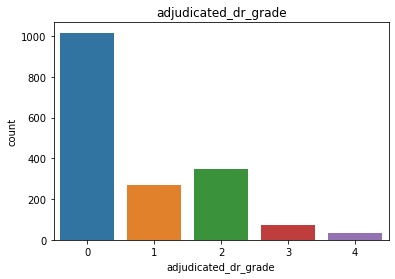

adjudicated_dr_grade
0    1017
1     270
2     347
3      75
4      35
Name: adjudicated_dr_grade, dtype: int64


In [6]:
column = 'adjudicated_dr_grade'
sns.countplot(data_info[column])
plt.title(column)
plt.show()
print(data_info[column].groupby(data_info[column]).count())

In [7]:
def make_grid(i):
    
    grade_4 = data_info[data_info['adjudicated_dr_grade'] == i]
    grade_4.reset_index(inplace = True)
    grade_4.drop('index' , axis = 1 , inplace = True)

    @interact(index=(0, len(grade_4)-1))
    def show_sample(index = 0):
        image_file = grade_4.iloc[index]['image_id']
        image_path = os.path.join('../dataset/IMAGES/' , image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(6,6))
        plt.title(i)
        plt.imshow(image)
        plt.show()


In [20]:
make_grid(0)
make_grid(1)
make_grid(2)
make_grid(3)
make_grid(4)

interactive(children=(IntSlider(value=0, description='index', max=269), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=0, description='index', max=346), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=0, description='index', max=74), Output()), _dom_classes=('widget-intera…

interactive(children=(IntSlider(value=0, description='index', max=34), Output()), _dom_classes=('widget-intera…

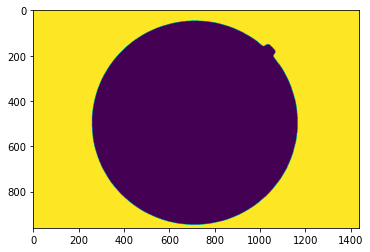

In [8]:
image_gray = cv2.imread('../dataset/IMAGES/20051216_45226_0200_PP.png', cv2.IMREAD_GRAYSCALE)
aug_img = cv2.threshold(image_gray, -1, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
test_img = aug_img[1]
plt.imshow(test_img)
plt.show()

In [9]:
test_img.shape

(960, 1440)

In [10]:
CenterX = test_img.shape[1] // 2
CenterY = test_img.shape[0] // 2

X = test_img[CenterY , :]
Y = test_img[: , CenterX]

X_count, Y_count = (X == 0).sum() ,(Y == 0).sum()

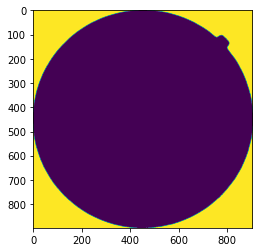

In [11]:
for idx_X , i in enumerate(X):
    if i != 255:
        break
        
for idx_Y , i in enumerate(Y):
    if i != 255:
        break

test_last_img = test_img[idx_Y: (idx_Y + Y_count), idx_X : (idx_X + X_count)]
plt.imshow(test_last_img)
plt.show()

In [12]:
img_list = os.listdir('../dataset/CUT_IMAGES/')

In [13]:
pixel_level = 'AdvancedBlur,Blur,CLAHE,ChannelDropout,ChannelShuffle,ColorJitter,Downscale,Emboss,Equalize,FDA,FancyPCA,FromFloat,GaussNoise,GaussianBlur,GlassBlur,HistogramMatching,HueSaturationValue,ISONoise,ImageCompression,InvertImg,MedianBlur,MotionBlur,MultiplicativeNoise,Normalize,PixelDistributionAdaptation,Posterize,RGBShift,RandomBrightnessContrast,RandomFog,RandomGamma,RandomRain,RandomShadow,RandomSnow,RandomSunFlare,RandomToneCurve,RingingOvershoot,Sharpen,Solarize,Superpixels,TemplateTransform,ToFloat,ToGray,ToSepia,UnsharpMask'
pixel_level = pixel_level.split(',')

In [14]:
other_pixel = ['FDA' , 'HistogramMatching' , 'PixelDistributionAdaptation' ,'TemplateTransform']

In [15]:
pixel_level = list(set(pixel_level) - set(other_pixel))

In [16]:
def trans(transformer):
    transform = transformer
    augmented_image = transform(image=IMG)['image']
    label = str(transformer).split('(')[0]
    return augmented_image , label

In [17]:
IMG = utils.imgread('../dataset/CUT_IMAGES/' + img_list[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


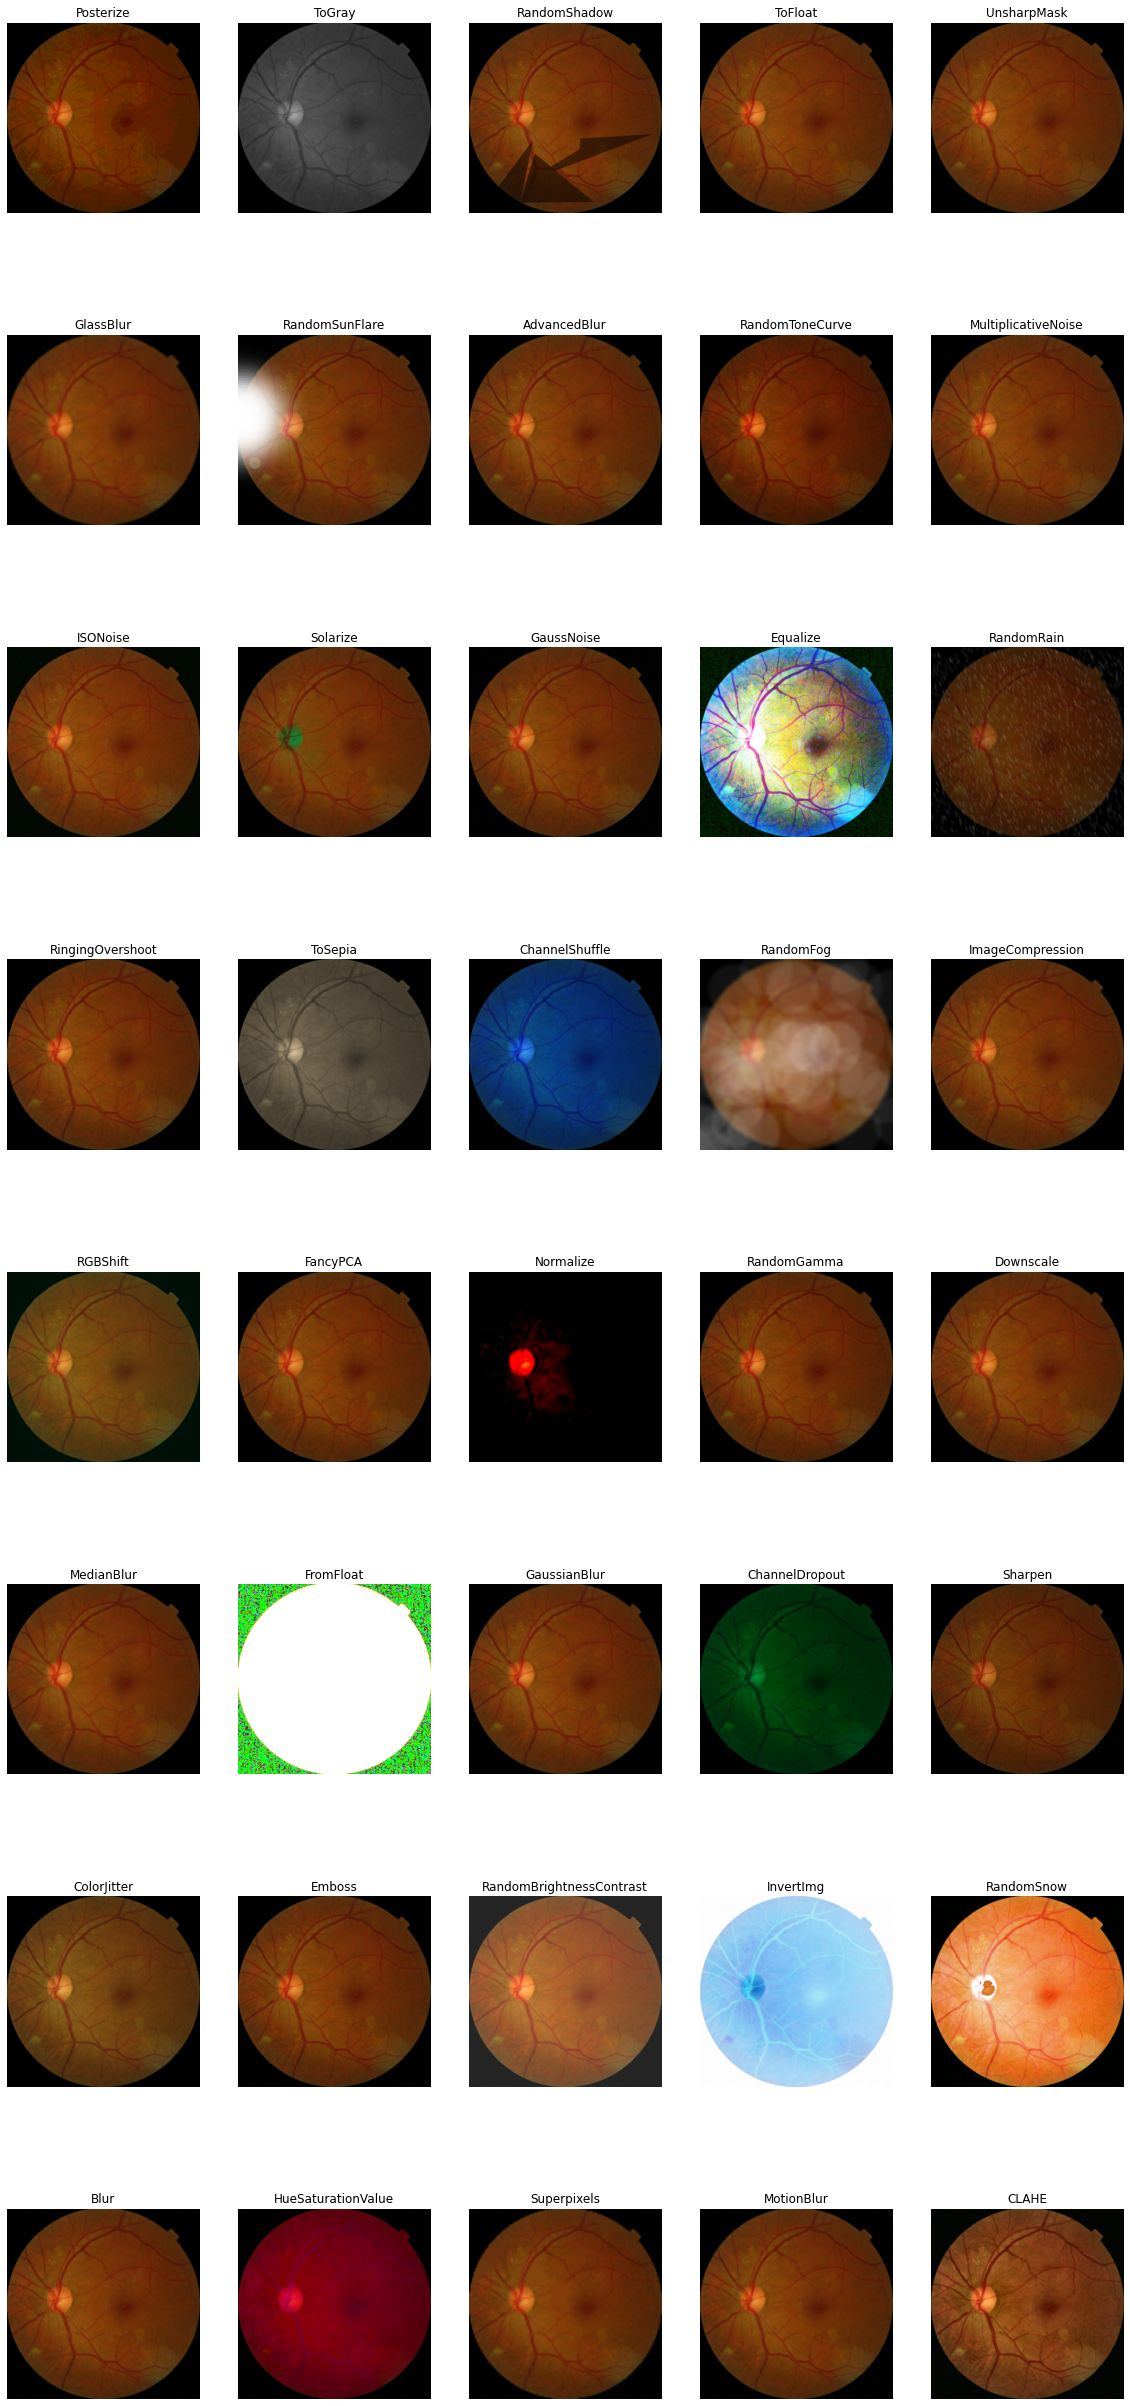

In [18]:
fig , ax = plt.subplots(8, 5, figsize = ( 20 , 45))
c = 0
x = 1
for i in range(8):
    for j in range(5):
        transformer = getattr(A , pixel_level[c])(always_apply = True)
        img , label = trans(transformer)
        ax[i, j].set_title(label)
        ax[i, j ].axis('off')
        ax[i, j ].imshow(img)
        c +=1
plt.show()